In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd
import scipy.optimize as optimize

from bo_functions import calc_y_exp
from bo_functions import create_y_data
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_ei_basic
from bo_functions import eval_GP_basic_tot
from bo_functions import create_sse_data
from bo_functions import eval_GP_basic_tot_scipy

from bo_plotters import plot_hyperparams
from bo_plotters import plot_xy
from bo_plotters import y_plotter
from bo_plotters import stdev_plotter
from bo_plotters import ei_plotter

In [2]:
#Pull x data from CSV
Theta_True = np.array([1,-1])
noise_std = 0.1**2
q = 2

exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)
# print(x)

In [3]:
#Pull training data from CSV
train_data_doc = "train_2_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
train_T = torch.tensor(train_data[:,1:3])
train_sse = torch.tensor(train_data[:,3])
# print(train_sse)

In [4]:
#Reduce Number of Training Points
t =len(train_T) #Desired number of training points
t = 3 #Set t=5 to show changing EI
train_T = train_T[0:t]
train_sse = train_sse[0:t]

In [5]:
#Define GP Testing space
#Define Testing Space
p=20
# Theta1 =  np.linspace(0.5,1.5,p) #1x10
# Theta2 =  np.linspace(-1.5,-0.5,p) #1x10
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]
# print(theta_mesh)

In [6]:
from scipy.optimize import basinhopping


class MyBounds(object):
     def __init__(self, xmax=[np.max(Theta1),np.max(Theta2)], xmin=[np.min(Theta1),np.min(Theta2)] ):
         self.xmax = np.array(xmax)
         self.xmin = np.array(xmin)

     def __call__(self, **kwargs):
         x = kwargs["x_new"]
         tmax = bool(np.all(x <= self.xmax))
         tmin = bool(np.all(x >= self.xmin))
         return tmax and tmin

1


/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Theta Best =  [ 1.23862926 -1.72744752]
Argmax Theta Best =  [ 1.15789474 -1.78947368]
Theta Opt =  [ 1.23859564 -1.72741582]
Argmin Theta_Opt_GP =  [ 1.15789474 -1.78947368]


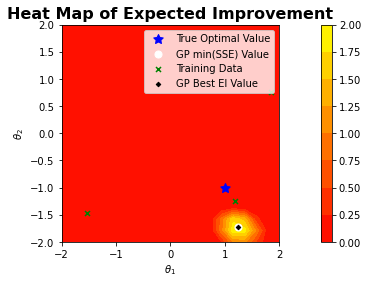

2
Theta Best =  [ 0.74237412 -1.09610056]
Argmax Theta Best =  [ 0.73684211 -1.15789474]
Theta Opt =  [ 0.94074457 -1.18220932]
Argmin Theta_Opt_GP =  [ 0.94736842 -1.15789474]


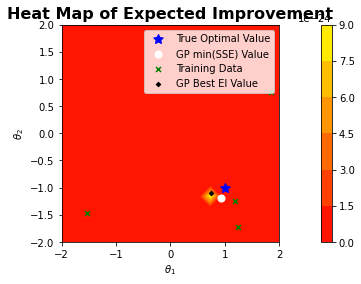

3
Theta Best =  [ 0.67179131 -1.06125198]
Argmax Theta Best =  [ 0.73684211 -1.15789474]
Theta Opt =  [ 0.70388106 -1.07702498]
Argmin Theta_Opt_GP =  [ 0.73684211 -1.15789474]


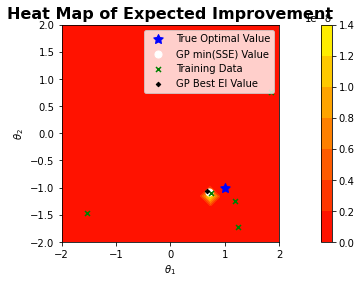

4
Theta Best =  [ 0.6628736  -1.05666756]
Argmax Theta Best =  [ 0.73684211 -1.15789474]
Theta Opt =  [ 0.67624236 -1.0633816 ]
Argmin Theta_Opt_GP =  [ 0.73684211 -1.15789474]


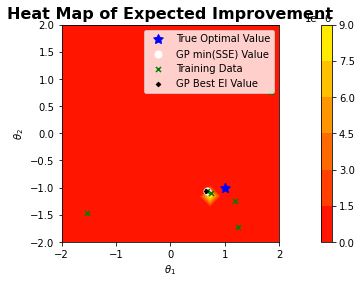

5
Theta Best =  [ 0.65855971 -1.05436447]
Argmax Theta Best =  [ 0.73684211 -1.15789474]
Theta Opt =  [ 0.6665789  -1.05844649]
Argmin Theta_Opt_GP =  [ 0.73684211 -1.15789474]


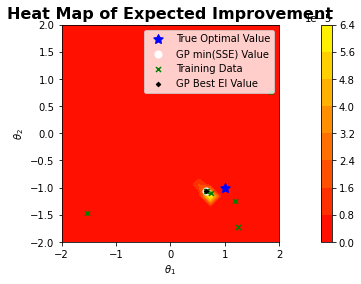

6
Theta Best =  [ 0.65610786 -1.05305093]
Argmax Theta Best =  [ 0.73684211 -1.15789474]
Theta Opt =  [ 0.66175298 -1.05595305]
Argmin Theta_Opt_GP =  [ 0.73684211 -1.15789474]


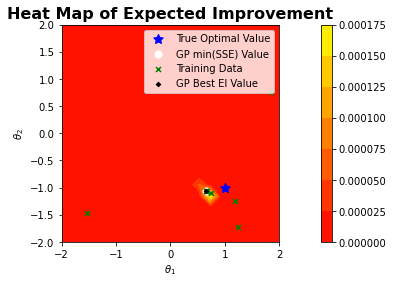

7
Theta Best =  [ 0.65452376 -1.05220893]
Argmax Theta Best =  [ 0.73684211 -1.15789474]
Theta Opt =  [ 0.65886638 -1.05445007]
Argmin Theta_Opt_GP =  [ 0.73684211 -1.15789474]


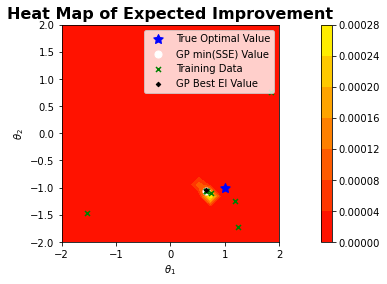

8
Theta Best =  [ 0.65343203 -1.05160409]
Argmax Theta Best =  [ 0.73684211 -1.15789474]
Theta Opt =  [ 0.65695815 -1.05343643]
Argmin Theta_Opt_GP =  [ 0.73684211 -1.15789474]


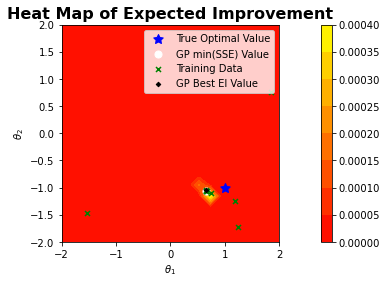

9
Theta Best =  [ 0.65263464 -1.05118502]
Argmax Theta Best =  [ 0.73684211 -1.15789474]
Theta Opt =  [ 0.65557818 -1.05271644]
Argmin Theta_Opt_GP =  [ 0.73684211 -1.15789474]


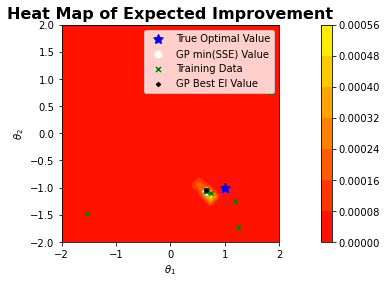

10
Theta Best =  [ 0.65201542 -1.0508374 ]
Argmax Theta Best =  [ 0.73684211 -1.15789474]
Theta Opt =  [ 0.65457928 -1.05217175]
Argmin Theta_Opt_GP =  [ 0.73684211 -1.15789474]


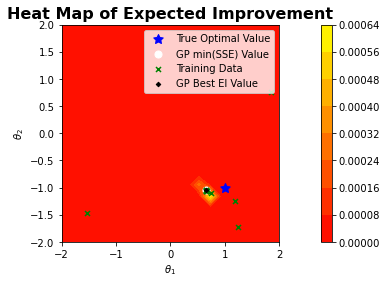

In [7]:
#Training the GP Model
iterations = 300
explore_bias = 0
verbose = True

BO_iter = 10
train_T_dict = {}
train_sse_dict = {}
ei_dict = {}
sse_dict ={}
var_dict ={}
GP_mean_best_dict = {}
GP_var_best_dict = {}
GP_mean_min_dict ={}
GP_var_min_dict = {}
Theta_Opt_dict = {}
Theta_Best_dict = {}
Best_Error_dict = {}
if verbose == True:
    z_dict = {}
    ei_term_1_dict = {}
    ei_term_2_dict = {}
    CDF_dict = {}
    PDF_dict = {}

for i in range(BO_iter):
    print(i+1)
    if torch.is_tensor(train_T) != True:
        train_T = torch.from_numpy(train_T)
    if torch.is_tensor(train_sse) != True:
        train_sse = torch.from_numpy(train_sse)
    
    train_T_dict[i+1] = train_T
    train_sse_dict[i+1] = train_sse
    # initialize likelihood and model
    ##Assumes a homoskedastic noise model p(y | f) = f + noise
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # We will use the simplest form of GP model, exact inference
    #Defines our model in terms of the class parameters in bo_functions
    model = ExactGPModel(train_T, train_sse, likelihood)
    train_GP = train_GP_model(model, likelihood, train_T, train_sse, iterations, verbose = False)
    
    ##Set Hyperparameters to 1
    outputscale = torch.tensor([1])
    lengthscale = torch.tensor([1])
    noise = torch.tensor([0.1])

    model.likelihood.noise = noise
    model.covar_module.base_kernel.lengthscale =lengthscale
    model.covar_module.outputscale = outputscale

    
    model.eval()
    #Puts likelihood in evaluation mode
    likelihood.eval()

    #Same point keeps being selected, should I remove that point by force?
    ei_components = eval_GP_basic_tot(p,theta_mesh, train_sse, model, likelihood, explore_bias, verbose)
    ei = ei_components[0]
    sse = ei_components[1]
#     print(sse)
    var = ei_components[2]
    stdev = ei_components[3]
    best_error = ei_components[4]
    if verbose == True:
        z = ei_components[5]
        ei_term_1 = ei_components[6]
        ei_term_2 = ei_components[7]
        CDF = ei_components[8]
        PDF = ei_components[9]
    
    ei_dict[i+1] = ei
    sse_dict[i+1] = sse
    var_dict[i+1] = var
    z_dict[i+1]=z
    
    Best_Error_dict[i+1] = best_error
    ei_term_1_dict[i+1] = ei_term_1
    ei_term_2_dict[i+1] = ei_term_2
    CDF_dict[i+1] = CDF
    PDF_dict[i+1] = PDF

    argmin = np.array(np.where(np.isclose(sse, np.amin(sse),atol=np.amin(sse)*1e-6)==True))
    Theta_1_Opt = float(theta1_mesh[argmin[0],argmin[1]])
    Theta_2_Opt = float(theta2_mesh[argmin[0],argmin[1]])
    Theta_Opt_GP = np.array((Theta_1_Opt,Theta_2_Opt))

    
    #calculates best theta value
    argmax = np.array(np.where(np.isclose(ei, np.amax(ei),atol=np.amax(ei)*1e-6)==True))
#     print(argmax)
    if len(argmax[0]) != 1:
        argmax = np.array([[argmax[0,1]],[argmax[1,1]]])
    
    Theta_1_Best = float(theta1_mesh[argmax[0],argmax[1]])
    Theta_2_Best = float(theta2_mesh[argmax[0],argmax[1]])
    Theta_Best = np.array((Theta_1_Best,Theta_2_Best))    
    
    #Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
    theta0_b = Theta_Best
    theta0_o = Theta_Opt_GP
#     theta0_b = theta0_o = [1.5,-1.5] #Causes only this point to be repeated
    
    bnds = ((np.min(Theta1), np.min(Theta2)), (np.max(Theta1), np.max(Theta2)))
    bnds = MyBounds()
    
    ei_sse_choice_b ="ei"
    minimizer_kwargs_b = {"method":"Nelder-Mead", "args":(train_sse, model, likelihood, explore_bias, ei_sse_choice_b)}

    ## use least squares optimizer in scipy?? IS LEAST SQUARES APPROPRIATE?
    
#     Best_Solution = optimize.least_squares(eval_GP_basic_tot_scipy, theta0_b,bounds=bnds, method='trf',args=((train_sse, model, likelihood, explore_bias, ei_sse_choice_b)))
#     Best_Solution = optimize.minimize(eval_GP_basic_tot_scipy, theta0_b,bounds=bnds, method='Nelder-Mead',args=((train_sse, model, likelihood, explore_bias, ei_sse_choice_b)))
    Best_Solution = basinhopping(eval_GP_basic_tot_scipy, theta0_b, accept_test = bnds, minimizer_kwargs = minimizer_kwargs_b)

    #     print(Solution)
    theta_b = Best_Solution.x
    print("Theta Best = ",theta_b)
    print("Argmax Theta Best = ",Theta_Best)
    
    ei_sse_choice_o = "sse"
    minimizer_kwargs_o = {"method":"Nelder-Mead", "args":(train_sse, model, likelihood, explore_bias, ei_sse_choice_o)}
#     Opt_Solution = optimize.least_squares(eval_GP_basic_tot_scipy, theta0_o,bounds=bnds, method='trf',args=((train_sse, model, likelihood, explore_bias, ei_sse_choice_o)))
#     Opt_Solution = optimize.minimize(eval_GP_basic_tot_scipy, theta0_o,bounds=bnds, method='Nelder-Mead',args=((train_sse, model, likelihood, explore_bias, ei_sse_choice_o)))
    Opt_Solution = basinhopping(eval_GP_basic_tot_scipy, theta0_o, accept_test = bnds, minimizer_kwargs = minimizer_kwargs_o)

    theta_o = Opt_Solution.x
    print("Theta Opt = ",theta_o)
    print("Argmin Theta_Opt_GP = ",Theta_Opt_GP)
    ##Using this method allows for small changes, but these points aren't reflected by the graphs (innacurate?)
    
    Theta_Opt_dict[i+1] = Theta_Opt_GP
    Theta_Best_dict[i+1] = Theta_Best

    GP_mean_min = sse[argmin[0],argmin[1]]
    GP_var_min = (stdev[argmin[0],argmin[1]])**2
    GP_mean_best = sse[argmax[0],argmax[1]]
    GP_var_best = (stdev[argmax[0],argmax[1]])**2
    
    GP_mean_best_dict[i+1] = GP_mean_best
    GP_var_best_dict[i+1] = GP_var_best
    GP_mean_min_dict[i+1] = GP_mean_min
    GP_var_min_dict[i+1] = GP_var_min
    
    sse_title = "SSE"
    ei_plotter(theta_mesh, ei, Theta_True, theta_o, theta_b,train_T,plot_train=True)
#     y_plotter(theta_mesh, sse, Theta_True, theta_o, theta_b, train_T,sse_title,plot_train=True)
#     ei_plotter(theta_mesh, ei, Theta_True, Theta_Opt_GP, Theta_Best,train_T,plot_train=True)
#     y_plotter(theta_mesh, sse, Theta_True, Theta_Opt_GP, Theta_Best, train_T,sse_title,plot_train=True)
    ##Append best values to training data 
    #Convert training data to numpy arrays to allow concatenation to work
    train_T = train_T.numpy() #(q x t)
    train_sse = train_sse.numpy() #(1 x t)

    #Call the expensive function and evaluate at Theta_Best
    sse_Best = create_sse_data(q,theta_b, Xexp, Yexp) #(1 x 1)
#     sse_Best = create_sse_data(q,Theta_Best, Xexp, Yexp) #(1 x 1)
 
    #Add Theta_Best to train_p and y_best to train_y
    train_T = np.concatenate((train_T, [theta_b]), axis=0) #(q x t)
#     train_T = np.concatenate((train_T, [Theta_Best]), axis=0) #(q x t)
    train_sse = np.concatenate((train_sse, [sse_Best]),axis=0) #(1 x t)
    


In [8]:
print(train_T_dict)
print(train_sse_dict)
print(Best_Error_dict)
print("\n",ei_dict)
#This is Expected 88

{1: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549]], dtype=torch.float64), 2: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549],
        [ 1.2386, -1.7274]], dtype=torch.float64), 3: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549],
        [ 1.2386, -1.7274],
        [ 0.7424, -1.0961]], dtype=torch.float64), 4: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549],
        [ 1.2386, -1.7274],
        [ 0.7424, -1.0961],
        [ 0.6718, -1.0613]], dtype=torch.float64), 5: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549],
        [ 1.2386, -1.7274],
        [ 0.7424, -1.0961],
        [ 0.6718, -1.0613],
        [ 0.6629, -1.0567]], dtype=torch.float64), 6: tensor([[ 1.8567,  0.7658],
        [-1.5359, -1.4589],
        [ 1.1929, -1.2549],
        [ 1.2386, -1.7274],
        [ 0.7424, -1.0961],
        [ 0.6718, -1.0613]

In [9]:
print("\nMax EIs")
for i in range(BO_iter):
    j=i+1
    print(np.amax(ei_dict[j]))

print("\nMin SSEs")
for i in range(BO_iter):
    j=i+1
    print(np.amin(sse_dict[j]))

##These are expected

print("\nBest EI GP Mean/Var")
print(GP_mean_best_dict)
print(GP_var_best_dict)

#GP Mean and EI Best vs Opt is the same. What does this mean?

print("\nLowest SSE GP Mean/Var")
print(GP_mean_min_dict)
print(GP_var_min_dict)
#Expected based on results above

for i in range(BO_iter):
    j = i+1
    argmax = np.array(np.where(np.isclose(ei_dict[j], np.amax(ei_dict[j]),atol=np.amax(ei_dict[j])*1e-6)==True))
    
    f_Best_a = Best_Error_dict[j][argmax[0],argmax[1]][0]
    print("\n f_Best",f_Best_a)
    print("EI_max:",np.amax(ei_dict[j]))
    print("GP Mean/Var:",GP_mean_best_dict[j],GP_var_best_dict[j])
    
    print("EI:",calc_ei_basic(f_Best_a,-GP_mean_best_dict[j],GP_var_best_dict[j], explore_bias))
#Max EIs are expected


print("\nTheta @ Lowest SSE")
print(Theta_Opt_dict)

#Expected based on results above
print("\nTheta @ Highest EI")
print(Theta_Best_dict)


# print("z values")
# print(z_dict[1],"\n", z_dict[2],"\n",z_dict[3])


# print("Term 1 values")
# print(ei_term_1_dict[1],"\n", ei_term_1_dict[2],"\n",ei_term_1_dict[3])

# print("Term 2 values")
# print(ei_term_2_dict[1],"\n", ei_term_2_dict[2],"\n",ei_term_2_dict[3])

# print("CDF")
# print(CDF[1],"\n", CDF[2],"\n",CDF[3])

# print("PDF")
# print(PDF[1],"\n", PDF[2],"\n",PDF[3])


Max EIs
1.9105498354036725
8.277535619972276e-24
1.2776812264821743e-08
8.429365569366401e-06
6.383901390685516e-05
0.00016366418959150894
0.0002787796603763086
0.00039102130544812824
0.0004932424259552464
0.0005836528985033035

Min SSEs
0.6374234054573975
7.848776994594333
3.0453852632310863
2.3254669732347217
2.0789355851239435
1.9584456027648116
1.8881497715418334
1.842537456425525
1.8107407255216668
1.7874169363136119

Best EI GP Mean/Var
{1: array([0.63742341]), 2: array([8.41297993]), 3: array([3.04538526]), 4: array([2.32546697]), 5: array([2.07893559]), 6: array([1.9584456]), 7: array([1.88814977]), 8: array([1.84253746]), 9: array([1.81074073]), 10: array([1.78741694])}
{1: array([0.41516868]), 2: array([0.36482356]), 3: array([0.17257332]), 4: array([0.14049857]), 5: array([0.12895306]), 6: array([0.12309727]), 7: array([0.11958186]), 8: array([0.11724647]), 9: array([0.11558655]), 10: array([0.11434788])}

Lowest SSE GP Mean/Var
{1: array([0.63742341]), 2: array([7.84877699

[ 0.73684211 -1.15789474]
[-14.10526316  -2.89473684   0.           0.57894737   4.84210526]
[-1.40031178e+01 -2.99270996e+00  2.17820788e-03  9.91009082e-01
  5.97513219e+00]


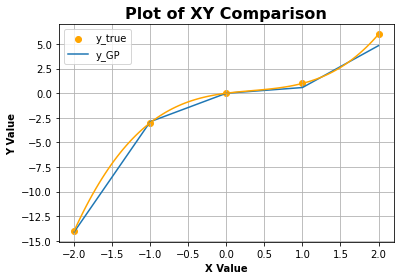

In [10]:
q_y = 3
y_GP_input = np.zeros((n,3))
for j in range(n):
    y_GP_input[j] = np.array([Theta_Best[0],Theta_Best[1],Xexp[j]])

y_GP_Opt = create_y_data(q_y,y_GP_input)
print(Theta_Opt_GP)
print(y_GP_Opt)
print(Yexp)

title = "XY Comparison"
plot_xy(Xexp, Yexp, y_GP_Opt,Theta_True,title)